cnn-trash-classifier

In [1]:
pip install tensorflow numpy pandas matplotlib scikit-learn huggingface-hub datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from datasets import load_dataset

dataset = load_dataset("garythung/trashnet")

C:\Users\jdarm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [112]:
import os
import numpy as np
import tensorflow as tf
import uuid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam

In [ ]:
import shutil

def prepare_data(dataset):
    base_path = "./trashnet_data"
    os.makedirs(base_path, exist_ok=True)

    for split in dataset.keys():
        split_path = os.path.join(base_path, split)
        os.makedirs(split_path, exist_ok=True)

        for data in dataset[split]:
            unique_id = uuid.uuid4()
            label = data['label']
            image = data['image']
            label_path = os.path.join(split_path, str(label))
            os.makedirs(label_path, exist_ok=True)
            
            image.save(os.path.join(label_path, f"{unique_id}.jpg"))

prepare_data(dataset)


In [131]:
image_size = 150
batch_size = 16
lr =  0.001

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    validation_split=0.2 
)

train_generator = train_datagen.flow_from_directory(
    './trashnet_data/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    './trashnet_data/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# for i in range(5):
#     images, labels = next(train_generator)
#     plt.subplot(1, 5, i+1)
#     plt.imshow(images[0])
#     plt.axis('off')
# plt.show()


Found 4046 images belonging to 6 classes.
Found 1008 images belonging to 6 classes.


In [132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax') 
])


In [133]:
model.compile(
    optimizer=Nadam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [134]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
181/253 ━━━━━━━━━━━━━━━━━━━━ 42s 591ms/step - accuracy: 0.3153 - loss: 8.3131

KeyboardInterrupt: 

In [101]:
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.2f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 608ms/step - accuracy: 0.7163 - loss: 0.8176
Validation Accuracy: 0.72


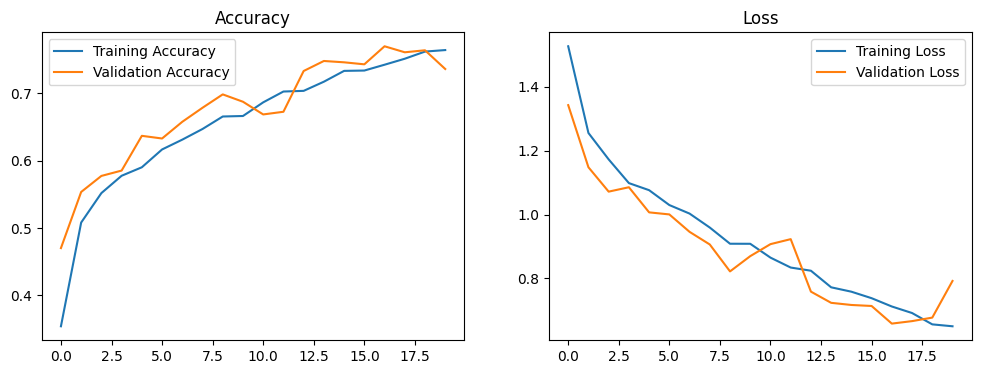

In [102]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [111]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image(image_path, model, class_indices):
    image = load_img(image_path, target_size=(image_size, image_size))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    class_name = list(class_indices.keys())[np.argmax(prediction)]
    match class_name:
        case '0':
            return 'cardboard'
        case '1':
            return 'glass'
        case '2':
            return 'metal'
        case '3':
            return 'paper'
        case '4':
            return 'plastic'
        case '5':
            return 'trash'

# Contoh prediksi
class_indices = train_generator.class_indices
print(predict_image('./trashnet_data/test/0/cardboard.jpg', model, class_indices))
print(predict_image('./trashnet_data/test/1/glass.jpg', model, class_indices))
print(predict_image('./trashnet_data/test/2/metal.jpg', model, class_indices))
print(predict_image('./trashnet_data/test/3/paper.jpg', model, class_indices))
print(predict_image('./trashnet_data/test/4/plastic.jpg', model, class_indices))
print(predict_image('./trashnet_data/test/5/trash2.jpg', model, class_indices))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
glass
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
metal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
paper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
plastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
trash
